# Script to evaluate the ML-Models

Setup (load automl-models.pickle)

In [75]:
import pickle
import csv

with open(r"../app/_meta.csv") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  list_qualities = list()
  for line in csv_reader:
    list_qualities.append(line[0])
  list_qualities = list_qualities[1:]

with open(r"../app/automl.pkl", "rb") as input_file:
  automl = pickle.load(input_file)

### Inspect the score:

In [76]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 10, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.7145538157834466, 'reg_alpha': 0.0015894113640782283, 'reg_lambda': 3.8394393702440004}
Best accuracy on validation data: 0.9027
Training duration of best run: 0.047 s


Test with a random dataset:

In [77]:
import openml as oml
import pandas as pd

dataset = oml.datasets.get_dataset(12)

t = dict()

for quality in list_qualities:
  t[quality] = [dataset.qualities.get(quality)]
test_df = pd.DataFrame(t)
print(dict(zip(automl.classes_, automl.predict_proba(test_df)[0])))
print(automl.predict(test_df)[0])

{'ATM': 0.46326390301513287, 'AutoGluon': 0.008325719245347387, 'FLAML': 0.3537015162412185, 'H2O AutoML': 0.020764343215877036, 'Hyperopt-Sklearn': 0.12258325726620202, 'TPOT': 0.010030649856999398, 'TransmogrifAI': 0.009188913512858773, 'auto-sklearn': 0.012141697646363955}
ATM


In [78]:
automl.classes_

array(['ATM', 'AutoGluon', 'FLAML', 'H2O AutoML', 'Hyperopt-Sklearn',
       'TPOT', 'TransmogrifAI', 'auto-sklearn'], dtype=object)

In [79]:
import lightgbm as lgb
import matplotlib.pyplot as plt

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

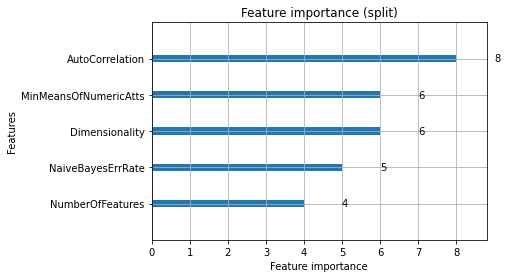

In [80]:
importance_type = 'split'
lgb.plot_importance(automl.model.estimator, max_num_features=5, importance_type=importance_type, title='Feature importance ({})'.format(importance_type))
plt.savefig('graphs/feature_importance.png', dpi=300, bbox_inches="tight")

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_tree.html#lightgbm.plot_tree

In [81]:
max_index = 31
index = 31
ax = lgb.create_tree_digraph(
  automl.model.estimator, 
  tree_index=index, 
  orientation='vertical', 
  name='Tree{}'.format(index))

ax.view()

'Tree31.gv.pdf'

In [83]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='logs/automl2022-09-09 15_59_18.040128.log', time_budget=60*60*2)

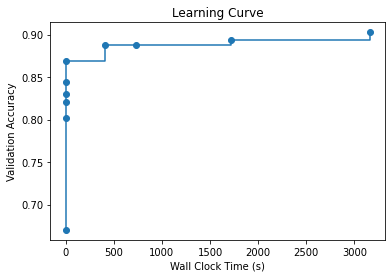

In [84]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.savefig('graphs/learning-curve.png', dpi=300, bbox_inches="tight")